In [ ]:
!pip install keras-core --upgrade
!pip install -q keras-nlp --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 691.2/691.2 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 53.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 93.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.18.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import keras_nlp
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


# Load the Disaster Tweets

In [ ]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")

print('Training Set Shape = {}'.format(df_train.shape))
print('Test Set Shape = {}'.format(df_test.shape))

Training Set Shape = (7613, 5)
Test Set Shape = (3263, 4)


In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# Explore the dataset

In [ ]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean      102.108183
std        33.972158
min         5.000000
25%        78.000000
50%       109.000000
75%       134.000000
max       151.000000
Name: length, dtype: float64


# Preprocess the data

In [ ]:
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE
EPOCHS = 10

In [ ]:
X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VAL_SPLIT, random_state=42)
X_test = df_test["text"]

In [ ]:
preset= "albert_base_en_uncased"
preprocessor = keras_nlp.models.AlbertPreprocessor.from_preset(preset, sequence_length=max(df_train['length']), name="preprocessor_layer")
base_albert = keras_nlp.models.AlbertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=2)

base_albert.summary()

100%|██████████| 611/611 [00:00<00:00, 1.52MB/s]


100%|██████████| 406/406 [00:00<00:00, 1.04MB/s]


100%|██████████| 742k/742k [00:00<00:00, 29.5MB/s]


100%|██████████| 44.6M/44.6M [00:00<00:00, 72.3MB/s]


Preprocessor: "preprocessor_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ albert_tokenizer (AlbertTokenizer)                            │                       Vocab size: 30,000 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "albert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ segment_ids (InputLayer)      │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ albert_backbone               │ [(None, 768), (None,      │      11,683,584 │ padding_mask[0][0],        │
│ (AlbertBackbone)              │ None, 768)]               │                 │ segment_ids[0][0],         │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ albert_backbone[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 11,685,122 (44.58 MB)

 Trainable params: 11,685,122 (44.58 MB)

 Non-trainable params: 0 (0.00 B)

#Create Callback and Checkpoint

In [ ]:
def create_callback(classifier, monitor='val_accuracy', patience=3, mode='max', filepath='model.keras'):

  early_stopping = EarlyStopping(
      monitor=monitor,
      patience=patience,
      restore_best_weights=True,
      verbose=0
  )

  checkpoint = ModelCheckpoint(
      filepath=filepath,
      monitor=monitor,
      save_best_only=True,
      mode=mode,
      verbose=0
  )

  return [early_stopping, checkpoint]

In [ ]:
base_callback = create_callback(base_albert, monitor='val_accuracy', patience=3, mode='max', filepath='base_albert.keras')

# Fine-tuning ALBERT

In [ ]:
# Compile
base_albert.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = base_albert.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=base_callback
                        )

base_albert.load_weights('base_albert.keras')

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.6916 - loss: 0.5743 - val_accuracy: 0.8004 - val_loss: 0.4483
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 234s 952ms/step - accuracy: 0.8199 - loss: 0.4228 - val_accuracy: 0.8070 - val_loss: 0.4481
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 208s 983ms/step - accuracy: 0.8590 - loss: 0.3463 - val_accuracy: 0.7833 - val_loss: 0.5348
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 180s 943ms/step - accuracy: 0.8802 - loss: 0.3035 - val_accuracy: 0.7965 - val_loss: 0.5147
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 203s 948ms/step - accuracy: 0.8880 - loss: 0.2824 - val_accuracy: 0.8030 - val_loss: 0.5189


#Show Learning Graph

In [ ]:
def plot_epoch_graph(history, title):

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title + ' model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title + ' model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

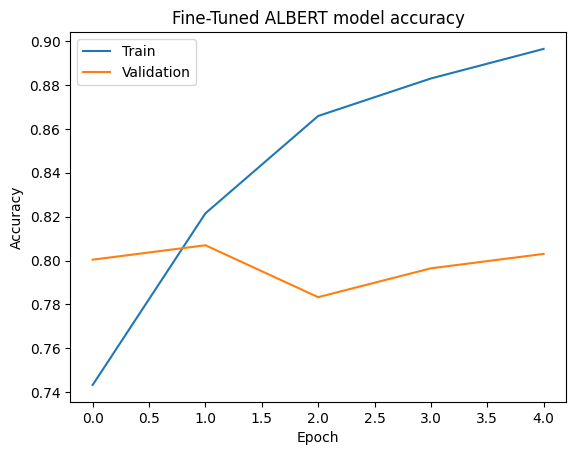

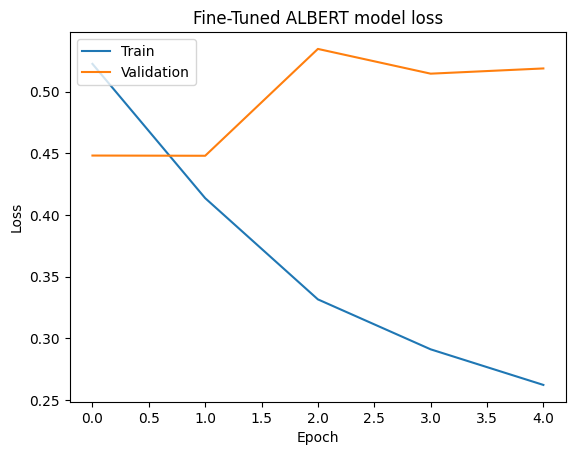

In [ ]:
plot_epoch_graph(history, "Fine-Tuned ALBERT")

In [ ]:
def display_confusion_matrices(classifier, X_train, y_train, X_val, y_val, title):

    def plot_confusion_matrix(y_true, y_pred, dataset):
        disp = ConfusionMatrixDisplay.from_predictions(
            y_true,
            np.argmax(y_pred, axis=1),
            display_labels=["Not Disaster", "Disaster"],
            cmap=plt.cm.Blues
        )

        tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
        f1_score = tp / (tp + ((fn + fp) / 2))

        disp.ax_.set_title(title + " confusion matrix on " + dataset + " -- F1 Score: " + str(f1_score.round(2)))

    y_pred_train = classifier.predict(X_train)
    y_pred_val = classifier.predict(X_val)

    plot_confusion_matrix(y_train, y_pred_train, "training")
    plot_confusion_matrix(y_val, y_pred_val, "validation")
    plt.show()

191/191 ━━━━━━━━━━━━━━━━━━━━ 61s 306ms/step
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 308ms/step


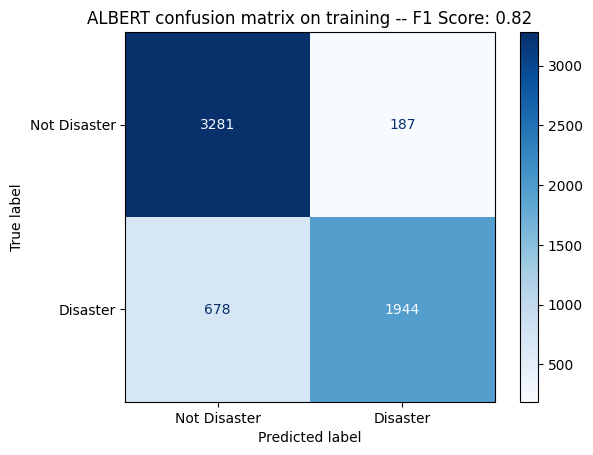

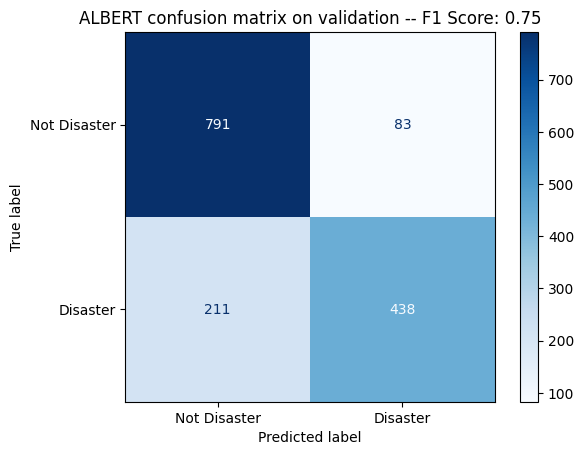

In [ ]:
display_confusion_matrices(base_albert, X_train, y_train, X_val, y_val, "ALBERT")

#Predict Test Data

In [ ]:
predictions = base_albert.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
df_test = pd.read_csv("./data/test.csv")
df_test["prediction"] = predicted_labels
df_test.drop(columns=["id", "keyword", "location"], inplace=True)
df_test.to_csv("albert_pred.csv", index=False)
df_test.head(10)

102/102 ━━━━━━━━━━━━━━━━━━━━ 32s 311ms/step


,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",0
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1
5,We're shaking...It's an earthquake,0
6,They'd probably still show more life than Arse...,0
7,Hey! How are you?,0
8,What a nice hat?,0
9,Fuck off!,0


# Prepare NLP Augmenter

In [ ]:
!pip install nlpaug
import nlpaug.augmenter.word as naw

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.1 MB/s eta 0:00:00


In [ ]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


#Preprocess Function

In [ ]:
def preprocess_text(text):
  if isinstance(text, list):
    text = ' '.join(text)
  text = text.lower()
  tokens = nltk.word_tokenize(text)
  tokens = [token for token in tokens if token not in stop_words]
  tokens = [lemmatizer.lemmatize(token) for token in tokens]
  text = ' '.join(tokens)
  return text

In [ ]:
X = df_train["text"].apply(preprocess_text)
y = df_train["target"]

aug = naw.SynonymAug(aug_src='wordnet')
X_train_augmented = X.apply(lambda text: preprocess_text(aug.augment(text)))
X_train_final = pd.concat([X, X_train_augmented])
y_train_final = pd.concat([y, y])

X_test_preprocessed = df_test["text"].apply(preprocess_text)
X_train, X_val, y_train, y_val = train_test_split(X_train_final, y_train_final, test_size=0.2, random_state=42)

#Re-train ALBERT

In [ ]:
new_callback = create_callback(base_albert, monitor='val_accuracy', patience=3, mode='max', filepath='new_model.keras')
new_model = keras_nlp.models.AlbertClassifier.from_preset(preset, preprocessor = preprocessor, num_classes=2)

In [ ]:
# Compile
new_model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=keras.optimizers.Adam(1e-5),
    metrics= ["accuracy"]
)

# Fit
history = new_model.fit(x=X_train,
                         y=y_train,
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val, y_val),
                         callbacks=new_callback
                        )

new_model.load_weights('new_model.keras')

Epoch 1/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 416s 1s/step - accuracy: 0.7370 - loss: 0.5333 - val_accuracy: 0.8224 - val_loss: 0.4088
Epoch 2/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 371s 974ms/step - accuracy: 0.8276 - loss: 0.3979 - val_accuracy: 0.8214 - val_loss: 0.4067
Epoch 3/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 372s 975ms/step - accuracy: 0.8690 - loss: 0.3244 - val_accuracy: 0.8398 - val_loss: 0.3869
Epoch 4/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 372s 975ms/step - accuracy: 0.9005 - loss: 0.2565 - val_accuracy: 0.8411 - val_loss: 0.3944
Epoch 5/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 371s 975ms/step - accuracy: 0.9320 - loss: 0.1926 - val_accuracy: 0.8457 - val_loss: 0.4244
Epoch 6/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 382s 975ms/step - accuracy: 0.9469 - loss: 0.1533 - val_accuracy: 0.8549 - val_loss: 0.4123
Epoch 7/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 382s 975ms/step - accuracy: 0.9647 - loss: 0.1091 - val_accuracy: 0.8562 - val_loss: 0.4510
Epoch 8/10
381/381 ━━━━━━━━━━━━━━━━━━━━ 357s 938ms/step - accuracy: 0.9663 - lo

#Show Learning Graph

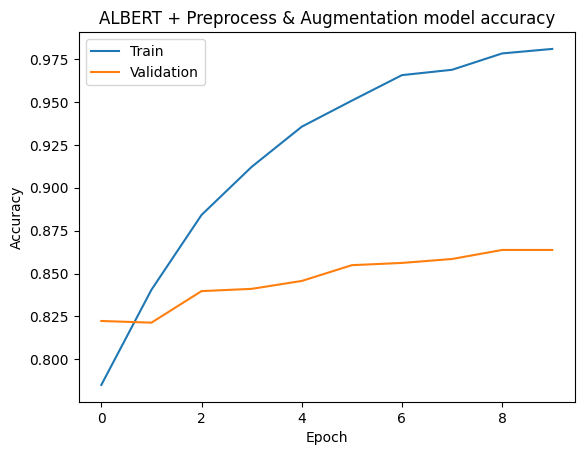

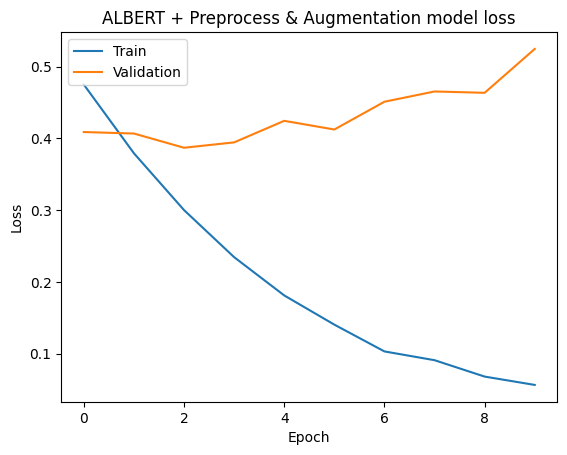

In [ ]:
plot_epoch_graph(history, "ALBERT + Preprocess & Augmentation")

381/381 ━━━━━━━━━━━━━━━━━━━━ 117s 297ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 29s 305ms/step


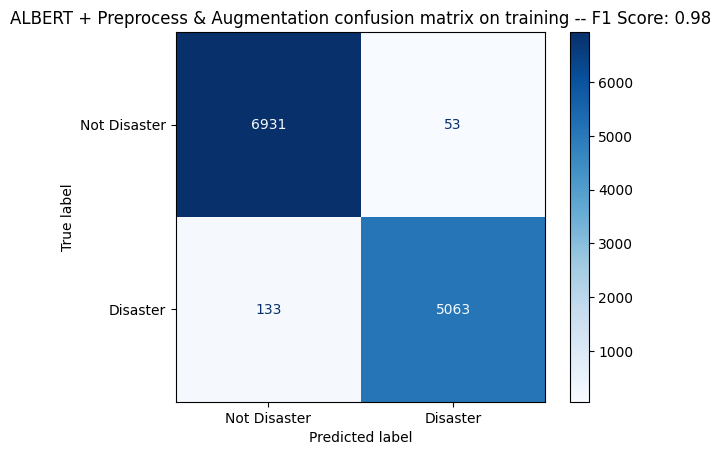

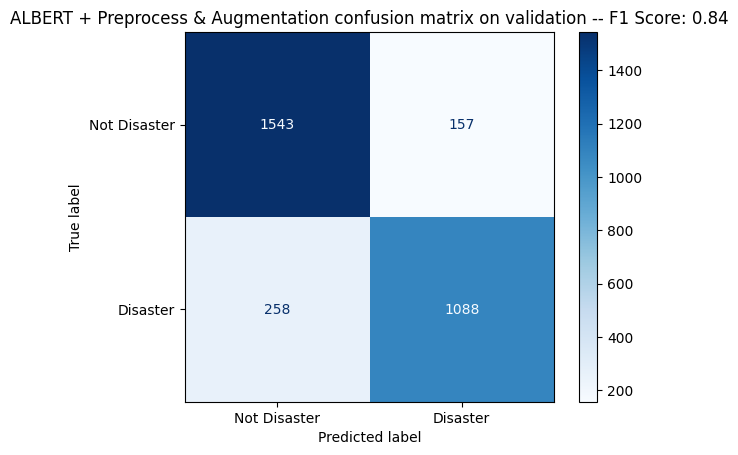

In [ ]:
display_confusion_matrices(new_model, X_train, y_train, X_val, y_val, "ALBERT + Preprocess & Augmentation")

#Predict Test Data

In [ ]:
predictions = new_model.predict(X_test_preprocessed)
predicted_labels = np.argmax(predictions, axis=1)
df_test = pd.read_csv("./data/test.csv")
df_test["prediction"] = predicted_labels
df_test.drop(columns=["id", "keyword", "location"], inplace=True)
df_test.to_csv("new_pred.csv", index=False)
df_test.head(10)

102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 349ms/step


,text,prediction
0,Just happened a terrible car crash,1
1,"Heard about #earthquake is different cities, s...",1
2,"there is a forest fire at spot pond, geese are...",1
3,Apocalypse lighting. #Spokane #wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,1
5,We're shaking...It's an earthquake,1
6,They'd probably still show more life than Arse...,0
7,Hey! How are you?,0
8,What a nice hat?,0
9,Fuck off!,0


#Perlihatkan Perbedaan Klasifikasi

In [ ]:
df_test = pd.read_csv("./data/test.csv")
df_albert_pred = pd.read_csv("albert_pred.csv")
df_new_pred = pd.read_csv("new_pred.csv")

df_albert_pred = df_albert_pred.rename(columns={"prediction": "albert_pred"})
df_new_pred = df_new_pred.rename(columns={"prediction": "new_pred"})

merged_df = pd.merge(df_test[["text"]], df_albert_pred[["albert_pred"]], left_index=True, right_index=True)
merged_df = pd.merge(merged_df, df_new_pred[["new_pred"]], left_index=True, right_index=True)

diff_pred = merged_df[merged_df["albert_pred"] != merged_df["new_pred"]]
diff_pred.to_csv("diff_pred.csv", index=False)

diff_pred

,text,albert_pred,new_pred
1,"Heard about #earthquake is different cities, s...",0,1
5,We're shaking...It's an earthquake,0,1
15,Birmingham Wholesale Market is ablaze BBC News...,0,1
17,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...,0,1
20,beware world ablaze sierra leone &amp; guap.,1,0
...,...,...,...
3243,'What manner of human being would parcel out a...,0,1
3256,To conference attendees! The blue line from th...,0,1
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,0,1
3261,MEG issues Hazardous Weather Outlook (HWO) htt...,0,1
